In [1]:
import pandas as pd
import numpy as np
import os
import json

# ML libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib
import matplotlib.pyplot as plt

# Makes plots inline
%matplotlib inline

print("All libraries loaded successfully!")

Matplotlib is building the font cache; this may take a moment.


All libraries loaded successfully!


In [2]:
dataset_path = "Epilepsy_dataset.csv"

df = pd.read_csv(dataset_path)
print(f"Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns.")

Dataset loaded with 4856 rows and 30 columns.


In [3]:
# Drops tiny classes
df_model = df[~df['Target/Epilepsy Type'].isin(['Not Confirmed', 'Normal'])].copy()

# Maps binary columns to 0/1
binary_map = {
    'On Medication': 0, 'Not on Medication': 1,
    'Yes': 1, 'No': 0
}

binary_cols = [
    'Medication Status', 'Alcohol or Drug Use', 'EEG Abnormality Detected',
    'Aura Before Seizure', 'Loss of Consciousness', 'Muscle Stiffness',
    'Jerky Movements', 'Postictal Confusion', 'Blank Stare Episodes',
    'Eye Rolling', 'Stress or Anxiety Before Episode', 'Lack of Sleep Before Episode',
    'Flashing Lights Sensitivity', 'Loud Sound Sensitivity', 'Missed Medication',
    'Family History of Epilepsy', 'Head Injury History', 'Brain Tumor',
    'History of Stroke', 'Genetic Disorder', 'Developmental Delay (in Children)'
]

for col in binary_cols:
    df_model[col] = df_model[col].map(binary_map)

# Encodes other categorical columns
from sklearn.preprocessing import LabelEncoder
categorical_cols = ['Gender', 'MRI/CT Scan Result', 'Seizure Type']
for col in categorical_cols:
    df_model[col] = LabelEncoder().fit_transform(df_model[col])


# Separates features and target
X = df_model.drop(columns=['Target/Epilepsy Type'])
y = df_model['Target/Epilepsy Type']

# Encodes categorical features
categorical_cols = ['Gender', 'MRI/CT Scan Result', 'Seizure Type']
for col in categorical_cols:
    X[col] = LabelEncoder().fit_transform(X[col])

# Splits dataset
le_target = LabelEncoder()
y_enc = le_target.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# Feature engineering: Seizure Load
X_train['Seizure_Load'] = X_train['Seizure Frequency'] * X_train['Seizure Duration']
X_test['Seizure_Load'] = X_test['Seizure Frequency'] * X_test['Seizure Duration']

# Trains model with balanced class weights
rf = RandomForestClassifier(
    n_estimators=780,
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train, y_train)

# Evaluation
y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le_target.classes_))

# Saves model
joblib.dump(rf, "kasper_rf_model.pkl")
print("Model trained and saved as kasper_rf_model.pkl")

Accuracy: 0.8424507658643327
              precision    recall  f1-score   support

     Absence       0.95      0.80      0.87       123
 Complicated       0.82      0.41      0.54        98
       Focal       0.81      0.87      0.84       283
 Generalized       0.84      0.94      0.89       410

    accuracy                           0.84       914
   macro avg       0.86      0.76      0.79       914
weighted avg       0.84      0.84      0.83       914

Model trained and saved as kasper_rf_model.pkl


In [4]:
importances = rf.feature_importances_
feature_names = X.columns

print("Model saw:", len(importances), "features")
print("DataFrame has:", len(feature_names), "columns")

missing_count = len(importances) - len(feature_names)
print(f"\nDifference: {missing_count} (extra feature importance(s))")

print("\nColumn names from DataFrame:")
for i, col in enumerate(feature_names):
    print(f"{i+1}. {col}")

Model saw: 30 features
DataFrame has: 29 columns

Difference: 1 (extra feature importance(s))

Column names from DataFrame:
1. Age
2. Gender
3. Weight
4. Height
5. Medication Status
6. Alcohol or Drug Use
7. EEG Abnormality Detected
8. MRI/CT Scan Result
9. Seizure Frequency
10. Seizure Duration
11. Seizure Type
12. Aura Before Seizure
13. Loss of Consciousness
14. Muscle Stiffness
15. Jerky Movements
16. Postictal Confusion
17. Blank Stare Episodes
18. Eye Rolling
19. Stress or Anxiety Before Episode
20. Lack of Sleep Before Episode
21. Flashing Lights Sensitivity
22. Loud Sound Sensitivity
23. Missed Medication
24. Family History of Epilepsy
25. Head Injury History
26. Brain Tumor
27. History of Stroke
28. Genetic Disorder
29. Developmental Delay (in Children)


Feature names length: 29
Importances length: 30
Top 15 Features Influencing Prediction:

                  Feature  Importance
10           Seizure Type    0.284925
12  Loss of Consciousness    0.071059
16   Blank Stare Episodes    0.066678
11    Aura Before Seizure    0.065351
14        Jerky Movements    0.064342
0                     Age    0.055264
2                  Weight    0.051554
3                  Height    0.051161
26      History of Stroke    0.024238
8       Seizure Frequency    0.022499
9        Seizure Duration    0.020189
15    Postictal Confusion    0.016752
7      MRI/CT Scan Result    0.016729
25            Brain Tumor    0.014642
1                  Gender    0.012824


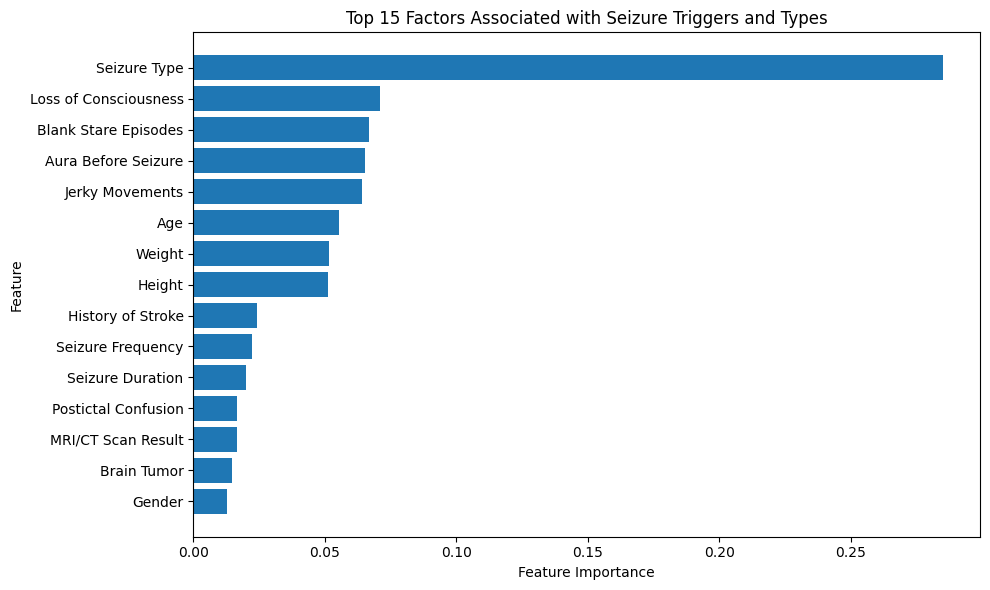

In [5]:
# Makes sure the model that was actually trained is used
model_used = best_rf if 'best_rf' in locals() else rf

# Matches importances to the *original DataFrame* columns
importances = model_used.feature_importances_

# Gets the column names from scaled data
feature_names = X.columns

# Sanity check
print("Feature names length:", len(feature_names))
print("Importances length:", len(importances))

min_len = min(len(importances), len(feature_names))

feat_importances = pd.DataFrame({
    'Feature': feature_names[:min_len],
    'Importance': importances[:min_len]
}).sort_values(by='Importance', ascending=False)

print("Top 15 Features Influencing Prediction:\n")
print(feat_importances.head(15))

# Visualizes the top 15 features
top_n = 15
plt.figure(figsize=(10, 6))
plt.barh(
    feat_importances.head(top_n)['Feature'],
    feat_importances.head(top_n)['Importance']
)
plt.gca().invert_yaxis()  # Places the highest importance at the top
plt.title('Top 15 Factors Associated with Seizure Triggers and Types')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [6]:
def kasper_setup():
    print("\nKASPER AI Seizure Log\n")
    print("This program helps identify possible seizure triggers based on your personal data and daily logs.\n")
    print("Disclaimer: KASPER AI is for informational purposes only and not a medical diagnostic tool.\n")

    user_profile = {}
    user_profile["Name"] = input("What's your name? ").strip()
    user_profile["Age"] = int(input("How old are you? "))
    user_profile["Gender"] = input("Gender (Male/Female/Other): ").capitalize()

    print("\nLet's collect some medical background.")
    user_profile["Epilepsy_Type"] = input("What type of epilepsy were you diagnosed with? (Focal/Generalized/Absence/Not Confirmed): ").capitalize()
    user_profile["On_Medication"] = input("Are you currently taking anti-seizure medication? (Yes/No): ").capitalize()
    user_profile["Family_History"] = input("Family history of epilepsy? (Yes/No): ").capitalize()
    user_profile["Known_Triggers"] = input("Known triggers (e.g., stress, sleep deprivation, flashing lights): ").lower()
    user_profile["Typical_Symptoms"] = input("What symptoms or auras do you usually experience before/during a seizure? ")

    # Saves user profiles
    with open("kasper_user.json", "w") as f:
        json.dump(user_profile, f, indent=4)

    print("\nSetup complete! Your profile has been saved.\nNext time, KASPER will use this data automatically.\n")
    return user_profile

In [7]:
def kasper_daily_log(user_profile):
    print(f"\nWelcome back, {user_profile['Name']}! Let's check how you're doing today.\n")

    log = {}
    log["Stress_Level"] = input("How stressed are you feeling (Low/Moderate/High)? ").capitalize()
    log["Sleep_Quality"] = input("How well did you sleep last night (Poor/Fair/Good)? ").capitalize()
    log["Missed_Medication"] = input("Did you miss your medication today? (Yes/No): ").capitalize()
    log["Flashing_Lights_Sensitivity"] = input("Did bright or flashing lights bother you today? (Yes/No): ").capitalize()
    log["Loud_Sound_Sensitivity"] = input("Were loud noises uncomfortable today? (Yes/No): ").capitalize()
    log["Physical_Strain"] = input("Did you experience physical exhaustion today? (Yes/No): ").capitalize()
    log["Mood_Swings"] = input("Any mood swings or emotional distress? (Yes/No): ").capitalize()
    log["Seizure_Activity"] = input("Did you have any seizure activity or aura sensations today? (Yes/No/Unsure): ").capitalize()

    triggers = []
    if log["Stress_Level"] == "High":
        triggers.append("stress")
    if log["Sleep_Quality"] == "Poor":
        triggers.append("lack of sleep")
    if log["Missed_Medication"] == "Yes":
        triggers.append("missed medication")
    if log["Flashing_Lights_Sensitivity"] == "Yes":
        triggers.append("flashing lights")
    if log["Loud_Sound_Sensitivity"] == "Yes":
        triggers.append("loud sounds")
    if log["Physical_Strain"] == "Yes":
        triggers.append("physical exhaustion")
    if log["Mood_Swings"] == "Yes":
        triggers.append("emotional stress")

    # Displays analysis
    print("\nKASPER's Analysis:")
    if triggers:
        print(f"Potential triggers detected today: {', '.join(triggers)}.")
        print("KASPER suggests getting rest, staying hydrated, and maintaining a calm environment.")
    else:
        print("No major trigger indicators found today — keep maintaining your healthy routine!")

    # Saves the log
    log["Name"] = user_profile["Name"]
    log["Epilepsy_Type"] = user_profile["Epilepsy_Type"]

    log_df = pd.DataFrame([log])
    if not os.path.exists("kasper_logs.csv"):
        log_df.to_csv("kasper_logs.csv", index=False)
    else:
        log_df.to_csv("kasper_logs.csv", mode="a", header=False, index=False)

    print("\nLog saved successfully.\n")
    return log_df


# Main flow
if os.path.exists("kasper_user.json"):
    with open("kasper_user.json", "r") as f:
        user_profile = json.load(f)
    print(f"\nProfile loaded. Welcome back, {user_profile['Name']}!\n")
else:
    user_profile = kasper_setup()

# Runs daily check-in
kasper_daily_log(user_profile)


KASPER AI Seizure Log

This program helps identify possible seizure triggers based on your personal data and daily logs.

Disclaimer: KASPER AI is for informational purposes only and not a medical diagnostic tool.



What's your name?  Kyle
How old are you?  20
Gender (Male/Female/Other):  Male



Let's collect some medical background.


What type of epilepsy were you diagnosed with? (Focal/Generalized/Absence/Not Confirmed):  Focal
Are you currently taking anti-seizure medication? (Yes/No):  Yes
Family history of epilepsy? (Yes/No):  No
Known triggers (e.g., stress, sleep deprivation, flashing lights):  Stress
What symptoms or auras do you usually experience before/during a seizure?  Dizziness



Setup complete! Your profile has been saved.
Next time, KASPER will use this data automatically.


Welcome back, Kyle! Let's check how you're doing today.



How stressed are you feeling (Low/Moderate/High)?  Moderate
How well did you sleep last night (Poor/Fair/Good)?  Fair
Did you miss your medication today? (Yes/No):  No
Did bright or flashing lights bother you today? (Yes/No):  No
Were loud noises uncomfortable today? (Yes/No):  No
Did you experience physical exhaustion today? (Yes/No):  No
Any mood swings or emotional distress? (Yes/No):  No
Did you have any seizure activity or aura sensations today? (Yes/No/Unsure):  No



KASPER's Analysis:
No major trigger indicators found today — keep maintaining your healthy routine!

Log saved successfully.



,Stress_Level,Sleep_Quality,Missed_Medication,Flashing_Lights_Sensitivity,Loud_Sound_Sensitivity,Physical_Strain,Mood_Swings,Seizure_Activity,Name,Epilepsy_Type
0,Moderate,Fair,No,No,No,No,No,No,Kyle,Focal
